In [1]:
from sys import path
path.append('..')
path.append('../src/')

import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from glob import glob
from os.path import join

from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model

from typing import List
from tensorflow.python.framework.ops import Tensor
from keras.layers import Layer

from custom_losses import wing_loss
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import eye_localization_accuracy, eye_localization_fvc
from icao_dataset import ICAODataset
from utils import load

%matplotlib inline

Using TensorFlow backend.


In [2]:
PATH_TO_ROOT = ".."
FOLDER_MODELS = "models"

FILE_MODEL_REQS = join(PATH_TO_ROOT, "models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5")
FILE_MODEL_EYES = join(PATH_TO_ROOT, "models/unsupervised_supervised/multilearner_2022_08_06-11_38_47.h5")
FILE_MODEL_PIXL = join(PATH_TO_ROOT, "models/multilearner_2022_12_17-22_10_44.h5")

# Load Base Models 

In [3]:
custom_objects = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "specificity": specificity,
    "fbeta": fbeta,
    "negative_predictive_value": npv,
    "matthews_correlation_coefficient": mcc,
    "wing_loss": wing_loss,
    "eye_localization_accuracy": eye_localization_accuracy
}

In [4]:
model_reqs = load_model(FILE_MODEL_REQS, custom_objects=custom_objects)
model_reqs.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0

In [5]:
model_eyes = load_model(FILE_MODEL_EYES, custom_objects=custom_objects)
model_eyes.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

In [6]:
model_pixl = load_model(FILE_MODEL_PIXL, custom_objects=custom_objects)
model_pixl.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

# Merge Models 

In [7]:
def get_layers(model: Model, list_names: List[str]) -> List[Layer]:
    return [model.get_layer(name=name) for name in list_names]

def append_layers_from_output(layer_output: Tensor, list_layers: List[Layer]) -> Tensor:
    x = layer_output
    for layer in list_layers:
        x = layer(x)
    return x

def rename_layers(layers: List[Layer], map_names: dict):
    for layer in layers:
        if layer.name in map_names:
            layer.name = map_names[layer.name]

In [8]:
list_layers = [
    "dropout_3",
    "dense_3",
    "dropout_4",
    "dense_4",
    "output_eyes"
]

layers_eyes = get_layers(model_eyes, list_layers)

embeddings = model_reqs.get_layer(name='global_average_pooling2d_1')
branch_eyes = append_layers_from_output(embeddings.output, layers_eyes)

In [9]:
list_layers = [
    "avg_pool_pixelation",
    "dropout_3",
    "dense_3",
    "dropout_4",
    "dense_4",
    "dropout_5",
    "dense_5",
    "output_pixelation",
]

dict_rename = dict(
    dropout_3="dropout_5",
    dense_3="dense_5",
    dropout_4="dropout_6",
    dense_4="dense_6",
    dropout_5="dropout_7",
    dense_5="dense_7",
)

layers_pixl = get_layers(model_pixl, list_layers)
rename_layers(layers_pixl, dict_rename)

pool_2 = model_reqs.get_layer(name="pool_2")
branch_pixl = append_layers_from_output(pool_2.output, layers_pixl)

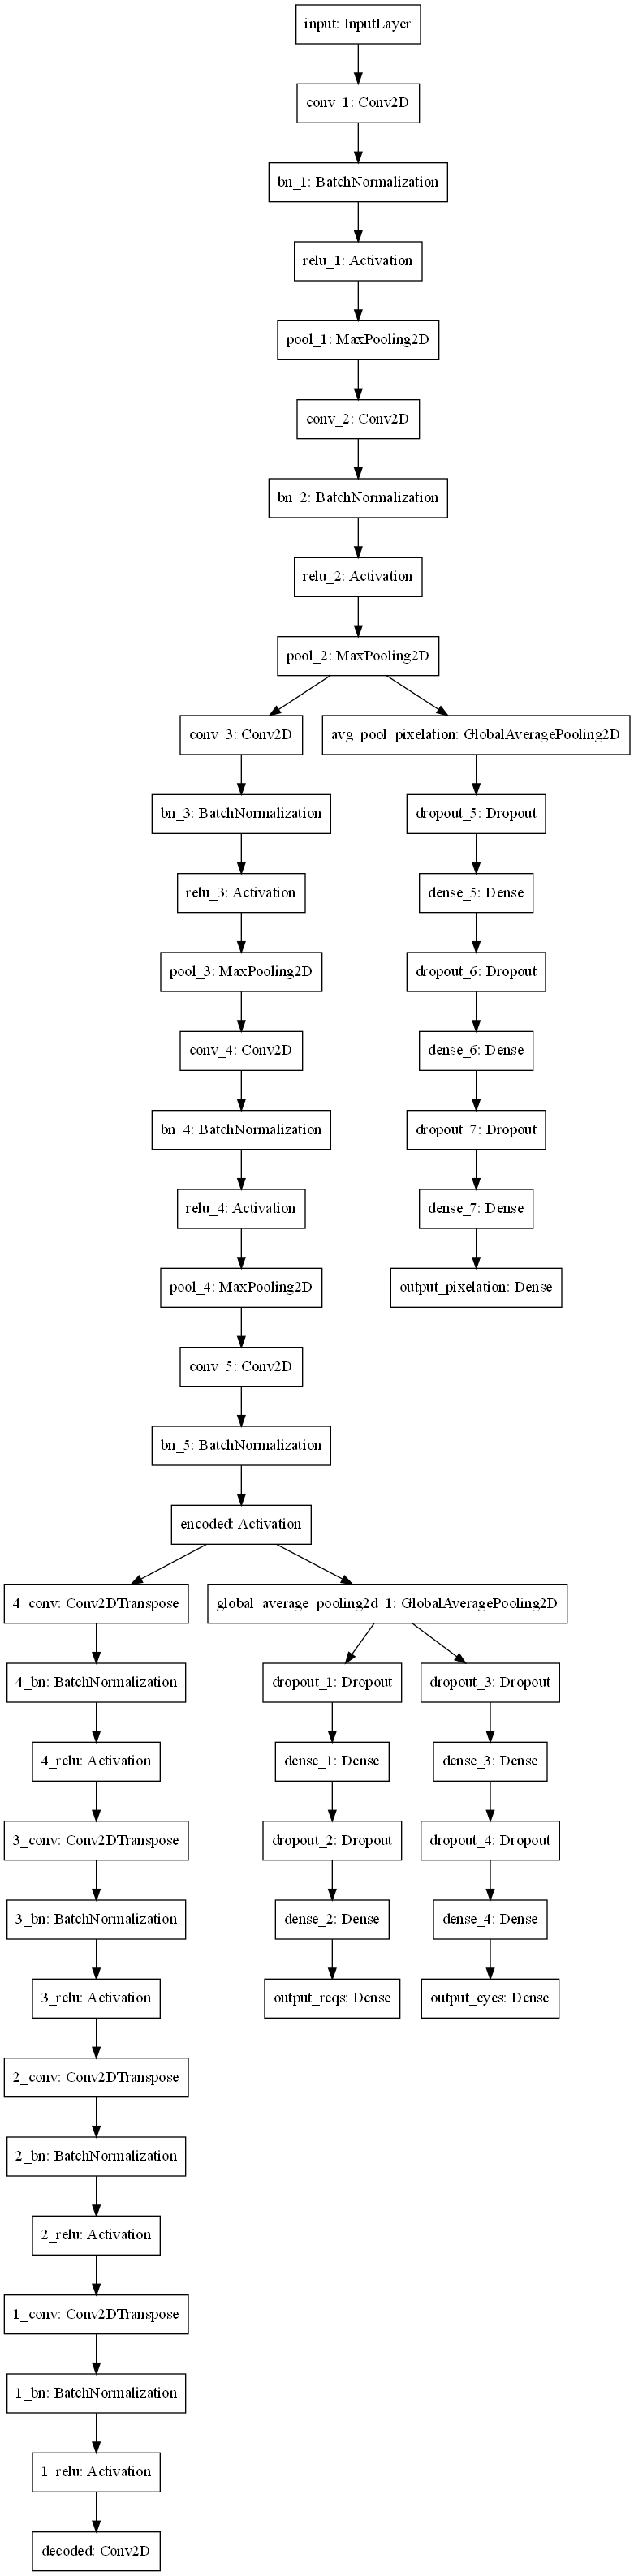

In [10]:
branch_decoded = model_reqs.get_layer(name="decoded")
branch_reqs = model_reqs.get_layer(name="outputs")
branch_reqs.name = "output_reqs"

final_model = Model(
    name="ICAONet",
    inputs=model_reqs.input, 
    outputs=[
        branch_decoded.output,
        branch_reqs.output, 
        branch_eyes,
        branch_pixl,
    ]
)
plot_model(final_model)

In [11]:
final_model.summary()

Model: "ICAONet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

In [12]:
FILE_OUTPUT = join(PATH_TO_ROOT, "models", "icaonet_with_decoder.h5")
print(FILE_OUTPUT)

final_model.save(FILE_OUTPUT)

..\models\icaonet_with_decoder.h5


# Save Classification Model 

In [13]:
final_model.get_output_at(0)

[<tf.Tensor 'decoded/Sigmoid:0' shape=(?, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'outputs/Sigmoid:0' shape=(?, 23) dtype=float32>,
 <tf.Tensor 'output_eyes_1/Sigmoid:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'output_pixelation_1/Sigmoid:0' shape=(?, 1) dtype=float32>]

In [14]:
FILE_MODEL_CLF = join(PATH_TO_ROOT, "models", "icaonet.h5")
print(FILE_MODEL_CLF)

model_clf = Model(
    name="ICAONet",
    inputs=final_model.inputs,
    outputs=final_model.get_output_at(0)[1:],
)
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

..\models\icaonet.h5
Model: "ICAONet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
_______________________________________________________________________

# Test Model 

In [15]:
model_clf = load_model(FILE_MODEL_CLF)

list_files = [join(PATH_TO_ROOT, 'data/cropped_faces/images/afwDB_0.png')]
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=(160, 160), interpolation=cv2.INTER_AREA)
im /= 255

y_pred_reqs, y_pred_eyes, y_pred_pixel = model_clf.predict(im)

print("Reqs:")
for y_pred in y_pred_reqs[0]:
    print(y_pred)

print("\nEyes:")
for y_pred in y_pred_eyes[0]:
    print(y_pred)
    
print("\nPixelation:")
for y_pred in y_pred_pixel[0]:
    print(y_pred)

..\data/cropped_faces/images/afwDB_0.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Reqs:
0.64809203
0.9347415
0.99573874
0.08281675
0.991169
0.9998725
0.97726715
0.27883765
0.96358013
0.053407997
0.20580027
0.1425302
0.9828384
0.47127602
0.8292506
0.99030715
0.7546117
0.97962976
0.89305204
0.65849006
0.9751569
0.827954
0.9905076

Eyes:
0.4198063
0.44754112
0.57570523
0.44433606

Pixelation:
0.48953563
